In [1]:
## using Pkg
## Pkg.add("PlotlyJS")

In [2]:
using DelimitedFiles
using LinearAlgebra
using Optim
using Distributions
using Test
using BenchmarkTools
using Random
using CSV
using DataFrames
using Distributed
using Plots

In [3]:
pwd()

"/Users/FredYu/Documents/GitHub/BulkLMM.jl/analysis"

In [60]:
## Include the source code of BulkLMM to be tested:
include("../src/scan.jl");
include("../src/lmm.jl");
include("../src/wls.jl");
include("../src/util.jl");
include("../src/kinship.jl");
include("../src/readData.jl");

## Also include the helper functions for writing tests:
include("../test/testHelper.jl");

In [5]:
## Read in BXD data:
pheno_file = "../data/bxdData/BXDtraits.csv"
pheno = readBXDpheno(pheno_file);
geno_file = "../data/bxdData/BXDgeno_prob.csv"
geno = readGenoProb_ExcludeComplements(geno_file);

kinship = calcKinship(geno); # calculate kinship matrix from genotype data

In [6]:
nperms = 1024; # number of permutated copies required;
m = size(pheno, 2);
p = size(geno, 2); # number of markers

heritabilities = Array{Float64, 1}(undef, m);


for j in 1:m
    heritabilities[j] = scan(reshape(pheno[:, j], :, 1), geno, kinship; reml = true)[2] 
end

histogram(heritabilities[1:7000], bins = 100)

length(heritabilities)

plot(heritabilities)

findmax(heritabilities)

In [35]:
## Consider the 7919-th trait
pheno_y = reshape(pheno[:, 7919], :, 1);

In [58]:
include("../src/scan.jl");

In [37]:
@btime scan_perms(pheno_y, geno, kinship; nperms = 100);

  910.247 ms (183990 allocations: 1.37 GiB)


In [38]:
@btime scan_perms(pheno_y, geno, kinship; nperms = 1024); # output structures of function

  7.326 s (194772 allocations: 13.63 GiB)


In [39]:
results_nperms = scan_perms(pheno_y, geno, kinship); # output structures of function

In [40]:
size(results_nperms)

(1025, 7321)

## Do the same for many traits (first 1000):

In [41]:
# Function that extracts the row maximums for a matrix:
function getMaxLod_manyTraits(pheno::Array{Float64, 2}, geno::Array{Float64, 2}, kinship::Array{Float64, 2};
                              ntraits::Int64 = 1000, nperms::Int64 = 1024, original::Bool = true)
    
    if original
        nrows = nperms+1
    else
        nrows = nperms
    end
    
    maxLods_manyTraits = Matrix{Float64}(undef, nrows, ntraits);
    
    for k in 1:ntraits
        
        pheno_k = reshape(pheno[:, k], :, 1);
        results = scan_perms(pheno_k, geno, kinship; nperms = nperms)
        
        maxLods_manyTraits[:, k] = getMaxLod(results)
    end
    
    return maxLods_manyTraits; 
end


function getMaxLod(results::Array{Float64, 2})
    
    return mapslices(x -> maximum(x), results; dims = 2);
    
end

getMaxLod (generic function with 1 method)

In [42]:
maxLods = getMaxLod(results_nperms);

In [43]:
typeof(maxLods)

Matrix{Float64} (alias for Array{Float64, 2})

In [44]:
size(maxLods)

(1025, 1)

In [45]:
quantile(maxLods[:, 1], 0.95)

3.75008800449138

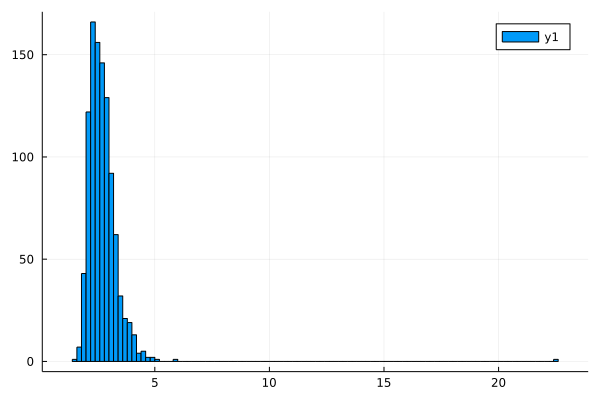

In [46]:
histogram(maxLods)

In [47]:
typeof(pheno_y)

Matrix{Float64} (alias for Array{Float64, 2})

In [48]:
@btime scan(pheno_y, geno, kinship);

  18.583 ms (101880 allocations: 34.44 MiB)


In [49]:
@btime scan_perms(pheno_y, geno, kinship; nperms = 0);

  27.824 ms (161026 allocations: 49.72 MiB)


In [61]:
@btime scan_perms(pheno_y, geno, kinship; nperms = 0);

  27.620 ms (161026 allocations: 49.72 MiB)


In [50]:
@btime getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 1, nperms = 1024);

  7.113 s (205853 allocations: 13.63 GiB)


In [51]:
@btime getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 100, nperms = 1);

  4.702 s (16198059 allocations: 6.18 GiB)


In [52]:
@btime getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 1000, nperms = 1);

  47.982 s (161743910 allocations: 61.70 GiB)


In [53]:
@btime getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 100, nperms = 10);

  12.493 s (16214259 allocations: 18.25 GiB)


In [54]:
@btime getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 1000, nperms = 10);

  123.939 s (161905911 allocations: 182.43 GiB)


In [55]:
@btime getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 100, nperms = 20);

  17.916 s (16232260 allocations: 31.54 GiB)


In [56]:
@btime getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 1000, nperms = 20);

  183.081 s (162085911 allocations: 315.33 GiB)


In [57]:
@btime getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 100, nperms = 100);

  87.673 s (18572660 allocations: 137.50 GiB)


In [158]:
@btime getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 1000, nperms = 100);

  1109.673 s (185488911 allocations: 1374.91 GiB)


In [ ]:
maxLods_1000Traits = getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 1000, nperms = 100);

In [ ]:
size(maxLods_1000Traits)

In [ ]:
quantile_1000Traits = mapslices(x -> quantile(x, 0.95), maxLods_1000Traits; dims = 1)

In [ ]:
histogram(vec(quantile_1000Traits), bins = 100)

In [ ]:
findmax(quantile_1000Traits)